In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 24.2 s, sys: 2.95 s, total: 27.1 s
Wall time: 29.6 s


(17937758, 9)

While attempting to train the model, it turned out that the reading and unpickling operation done at this scale, with so many files, is very computationally expensive.

But the examples in the mfcc represenatations are very small. Let's read them all into the memory before training.

In [3]:
# uniq_fns = np.unique(df.target_fn.values)

In [4]:
# %%time

# fn2feature = {}
# for fn in uniq_fns:
#     ary = pd.read_pickle(f'data/examples/{fn}.pkl')
#     fn2feature[fn] = ary

# pd.to_pickle(fn2feature, 'data/fn2feature.pkl')

In [5]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 17.2 s, sys: 12.4 s, total: 29.6 s
Wall time: 2min 26s


In [6]:
vocab = list(df.source_word.unique())

In [7]:
# from collections import Counter
# counter = Counter(df.source_word)

# most_common_words = set([t[0] for t in counter.most_common(1000)])

In [8]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target,audio_fpath
0,I,FELT,8af4aebcf4a74004b02db9f88d99e89a,1cb9442ec1a6468282da309756e2ff57,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
1,I,THAT,8af4aebcf4a74004b02db9f88d99e89a,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
2,FELT,I,1cb9442ec1a6468282da309756e2ff57,8af4aebcf4a74004b02db9f88d99e89a,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
3,FELT,THAT,1cb9442ec1a6468282da309756e2ff57,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
4,FELT,IT,1cb9442ec1a6468282da309756e2ff57,155ad336d88c4cbf814a1237983b5b18,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac


In [11]:
%%time

unique_fns = df.source_fn.unique()
np.random.shuffle(unique_fns)
lengths = []
for i, features in enumerate(fn2features.values()):
    lengths.append(features.shape[0])

CPU times: user 4.91 s, sys: 172 ms, total: 5.08 s
Wall time: 5.08 s


In [12]:
max(lengths)

291

In [13]:
np.mean(lengths)

29.028019713968394

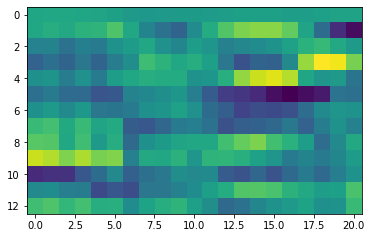

In [14]:
plt.imshow(features.T)

In [15]:
dataset_mean = -5
dataset_std = 15

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [16]:
def empty_list(): return list()

In [17]:
# %%time

# word2row_idxs = defaultdict(empty_list)

# for idx, row in df.iterrows():
#     word2row_idxs[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs, 'data/word2row_idxs.pkl')

In [18]:
word2row_idxs = pd.read_pickle('data/word2row_idxs.pkl')

In [19]:
def prepare_features(fn, pad_to=100, pad_left=False):
    ary = fn2features[fn][:pad_to]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [20]:
if np.nan in vocab: vocab.remove(np.nan)

In [22]:
class Dataset():
    def __init__(self, n):
        self.vocab = vocab * n
    def __len__(self):
        return len(self.vocab)
    def __getitem__(self, idx):
        row_idx = np.random.randint(len(word2row_idxs[self.vocab[idx]]))
        source_fn = df.source_fn[row_idx]
        target_fn = df.target_fn[row_idx]
        x = normalize_data(prepare_features(source_fn, pad_left=True))
        y = normalize_data(prepare_features(target_fn))
        return np.stack((x, y)), y

In [25]:
BS = 2048
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(Dataset(270), BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(Dataset(30), BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [26]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

In [174]:
t = torch.zeros(1,1,50,20)

In [ ]:
# # unidirectional encoder
# teacher_forcing_ratio = 0
# class Model(Module):
#     def __init__(self, hidden_size=50, num_layers_encoder=2):
#         self.num_layers_encoder = num_layers_encoder
        
#         self.encoder= nn.LSTM(
#             input_size=13,
#             hidden_size=hidden_size,
#             num_layers=self.num_layers_encoder,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.decoder = nn.LSTM(
#             input_size=hidden_size+13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.lin1 = nn.Linear(hidden_size, hidden_size)
#         self.lin2 = nn.Linear(hidden_size, 13)
            
#     def forward(self, source_and_target_features):
#         source_features = source_and_target_features[:, 0]
#         target_features = source_and_target_features[:, 1]
#         _, (embeddings, _) = self.encoder(source_features)

#         outputs = torch.zeros_like(target_features)
        
#         embeddings = embeddings[self.num_layers_encoder-1:self.num_layers_encoder]
#         hidden = embeddings
#         # hidden = torch.zeros_like(embeddings)
#         cell = torch.zeros_like(embeddings)

#         input = torch.zeros((target_features.shape[0], 1, target_features.shape[2])).cuda()
#         for t in range(target_features.shape[1]):
#             input = torch.cat((input, embeddings.squeeze(0).unsqueeze(1)), 2)
#             x, (hidden, cell) = self.decoder(input, (hidden, cell))
#             x = self.lin1(x)
#             x = nn.functional.relu(x)
#             x = self.lin2(x)
#             input = (torch.sigmoid(x) - 0.5) * 16
#             outputs[:, t, :] = input.squeeze()
            
#             if random.random() < teacher_forcing_ratio:
#                 input = target_features[:, t, :].unsqueeze(1)
#         return outputs

In [310]:
# unidirectional encoder
teacher_forcing_ratio = 0
class Model(Module):
    def __init__(self, hidden_size=50, num_layers_encoder=2):
        self.return_embeddings = False
        self.num_layers_encoder = num_layers_encoder
        self.hidden_size = hidden_size
        
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=self.num_layers_encoder,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        self.decoder = nn.LSTM(
            input_size=hidden_size+13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.lin1 = nn.Linear(hidden_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, 13)
            
    def forward(self, source_and_target_features):
        source_features = source_and_target_features[:, 0]
        target_features = source_and_target_features[:, 1]
        _, (embeddings, _) = self.encoder(source_features)

        outputs = torch.zeros_like(target_features)
        
        embeddings = embeddings.view(self.num_layers_encoder, 2, source_features.shape[0], self.hidden_size)
        embeddings = embeddings[self.num_layers_encoder-1:self.num_layers_encoder].sum(1)
        if self.return_embeddings: return embeddings
        hidden = embeddings
        # hidden = torch.zeros_like(embeddings)
        cell = torch.zeros_like(embeddings)

        input = torch.zeros((target_features.shape[0], 1, target_features.shape[2])).cuda()
        for t in range(target_features.shape[1]):
            input = torch.cat((input, embeddings.squeeze(0).unsqueeze(1)), 2)
            x, (hidden, cell) = self.decoder(input, (hidden, cell))
            x = self.lin1(x)
            x = nn.functional.relu(x)
            x = self.lin2(x)
            input = (torch.sigmoid(x) - 0.5) * 16
            outputs[:, t, :] = input.squeeze()
            
            if random.random() < teacher_forcing_ratio:
                input = target_features[:, t, :].unsqueeze(1)
        return outputs

In [311]:
learn = Learner(dls.cuda(), Model().cuda(), loss_func=MSELoss(), lr=1e-3, opt_func=Adam)

In [261]:
# teacher_forcing_ratio = 0.25
learn.fit(4, cbs=SaveModelCallback(fname='1e-3_Adam_first_input_all_zeros', every_epoch=True), lr=1e-3)

KeyboardInterrupt: 

In [312]:
learn.load('1e-3_Adam_first_input_all_zeros_0')

In [199]:
# teacher_forcing_ratio = 0.25
learn.fit(4, cbs=SaveModelCallback(fname='1e-3_Adam_first_input_all_zeros', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.124459,0.124584,28:37
1,0.123489,0.123433,29:17
2,0.123182,0.122871,30:10
3,0.122540,0.122452,30:39


In [32]:
# for batch in train_dl:
#     break

# o = learn.model(batch[0].cuda())
# plt.imshow(o[0][:5, :].detach().cpu())

# plt.imshow(batch[1][0][:5, :].detach().cpu())

## Calculate embedding for each unique word in the dataset

In [296]:
df_unique_utterances = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])].drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

In [297]:
class DatasetAllUtterances():
    def __len__(self):
        return df_unique_utterances.shape[0]
    def __getitem__(self, idx):
        source_fn = df_unique_utterances.iloc[idx].source_fn
        target_fn = df_unique_utterances.iloc[idx].target_fn
        x = normalize_data(prepare_features(source_fn, pad_left=True))
        y = normalize_data(prepare_features(target_fn))
        return np.stack((x, y)), y

In [298]:
all_dl = DataLoader(DatasetAllUtterances(), BS, NUM_WORKERS)

In [299]:
for batch in all_dl:
    break

In [316]:
%%time

learn.model.return_embeddings = True
learn.model.train = False

all_embeddings = []

with torch.no_grad():    
    for batch in all_dl:
        embeddings = learn.model(batch[0].cuda())
        all_embeddings.append(embeddings.detach().cpu().squeeze(0))

CPU times: user 45.8 s, sys: 16.9 s, total: 1min 2s
Wall time: 5min 17s


In [317]:
all_embeddings = torch.cat(all_embeddings)

In [318]:
all_embeddings.shape

torch.Size([4638516, 50])

In [319]:
learn.model.return_embeddings = False

with torch.no_grad():
    for i, batch in enumerate(all_dl):
        outputs = learn.model(batch[0].cuda())
        break

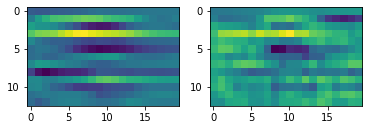

In [320]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[305].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][305].cpu().numpy().T[:, :20])

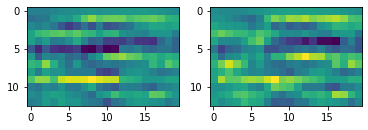

In [321]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[0].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][0].cpu().numpy().T[:, :20])

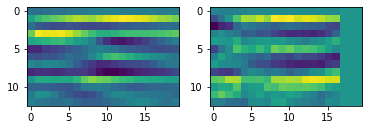

In [322]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[30].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][30].cpu().numpy().T[:, :20])

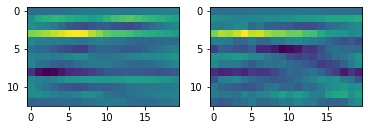

In [323]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[35].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][35].cpu().numpy().T[:, :20])

In [324]:
# %%time

# word2row_idxs_unique_utterances = defaultdict(empty_list)

# for idx, row in df_unique_utterances.iterrows():
#     word2row_idxs_unique_utterances[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs_unique_utterances, 'word2row_idxs_unique_utterances.pkl')

In [325]:
word2row_idxs_unique_utterances = pd.read_pickle('word2row_idxs_unique_utterances.pkl')

In [326]:
word2embedding = {}

for k, v in word2row_idxs_unique_utterances.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0)

In [ ]:
word2embedding_without_nans= {}
nans_encountered = 0
for k, v in word2embedding.items():
    if k in vocab and k == k and (not np.isnan(v.numpy()).any()):
        word2embedding_without_nans[k] = v.numpy()
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

In [ ]:
class Embeddings():
    def __init__(self, embeddings, index2word):
        '''embeddings - numpy array of embeddings, index2word - list of words corresponding to embeddings'''
        assert len(embeddings) == len(index2word)
        self.vectors = embeddings
        self.i2w = index2word
        self.w2i = {w:i for i, w in enumerate(index2word)}
            
    def analogy(self, a, b, c, n=5, discard_question_words=True):
        '''
        a is to b as c is to ?
        
        Performs the following algebraic calculation: result = emb_a - emb_b + emb_c
        Looks up n closest words to result.
        
        Implements the embedding space math behind the famous word2vec example:
        king - man + woman = queen
        '''
        question_word_indices = [self.w2i[word] for word in [a, b, c]]
        a, b, c = [self.vectors[idx] for idx in question_word_indices] 
        result = a - b + c
        
        if discard_question_words: return self.nn_words_to(result, question_word_indices, n)
        else:                      return self.nn_words_to(result, n=n)
        
    def nn_words_to(self, vector, skip_indices=[], n=5):
        nn_indices = self.word_idxs_ranked_by_cosine_similarity_to(vector)
        nn_words = []
        for idx in nn_indices:
            if idx in skip_indices: continue
            nn_words.append(self.i2w[idx])
            if len(nn_words) == n: break
        
        return nn_words
    
    def word_idxs_ranked_by_cosine_similarity_to(self, vector):
        return np.flip(
            np.argsort(self.vectors @ vector / (self.vectors_lengths() * np.linalg.norm(vector, axis=-1)))
        )
    
    def vectors_lengths(self):
        if not hasattr(self, 'vectors_length_cache'):
            self.vectors_length_cache = np.linalg.norm(self.vectors, axis=-1)
        return self.vectors_length_cache
    
    def __getitem__(self, word):
        return self.vectors[self.w2i[word]]
    
    @classmethod
    def from_txt_file(cls, path_to_txt_file, limit=None):
        '''create embeddings from word2vec embeddings text file'''
        index, vectors = [], []
        with open(path_to_txt_file) as f:
            f.readline() # discarding the header line
            for line in f:
                try:
                    embedding = np.array([float(s) for s in line.split()[1:]])
                    if embedding.shape[0] != 300: continue
                    vectors.append(embedding)
                    index.append(line.split()[0])
                except ValueError: pass # we may have encountered a 2 word embedding, for instance 'New York' or 'w dolinie'
                if limit is not None and len(vectors) == limit: break
        return cls(np.stack(vectors), index)

In [ ]:
e = Embeddings(
    np.array(list(word2embedding_without_nans.values())),
    [w.lower() for w in list(word2embedding_without_nans.keys())]
)

In [ ]:
e.nn_words_to(e['fast'])

In [ ]:
e.nn_words_to(e['lost'])

In [ ]:
e.nn_words_to(e['true'])

In [ ]:
e.nn_words_to(e['virtue'])

In [ ]:
e.nn_words_to(e['germany'])

In [ ]:
e.nn_words_to(e['crazy'])

In [ ]:
e.nn_words_to(e['slow'])

## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [ ]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [ ]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [ ]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

In [ ]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))